# 1. get intersections between ebutterfly and ebird data

In [33]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from haversine import haversine, Unit
from sklearn.neighbors import BallTree
import os

root_dir = "/home/hagerradi/projects/Ecosystem_embeddings/ebutterfly/Darwin/0177350-230224095556074"
dataset_tag = "ebutterfly_data_v2"

buttefly_data_US = pd.read_csv(os.path.join(root_dir, "occ_usa.csv"))

satbird_USA_summer = pd.read_csv(os.path.join(root_dir, "all_summer_hotspots_no_nans.csv"))

print(satbird_USA_summer)
print(buttefly_data_US)

RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X):
        self.X_train = X
        self.tree = BallTree(np.deg2rad(X), metric='haversine')

    def haversine_distance(self, x1, x2):
        return haversine((x1[0], x1[1]), (x2[0], x2[1]), unit=Unit.KILOMETERS)

    def predict_slow(self, X):
        dist, index = [], []
        for x in tqdm(X):
            d, i = self._predict_single(x)
            dist.append(d)
            index.append(i)
        return np.array(dist), np.array(index)
    
    def predict(self, X):
        dist, index = self.tree.query(np.deg2rad(X), k=self.k)
        dist = dist * RADIUS_EARTH
        return dist, index

    def _predict_single(self, x):
        # Compute distances between x and all examples in the training set
        distances = [self.haversine_distance(x, x_train) for x_train in self.X_train]
        # Get indices of k nearest neighbors
        return min(distances), np.argmin(distances)

coordinates = buttefly_data_US[['decimalLatitude', 'decimalLongitude']].values
center_coordinates = satbird_USA_summer[['lat', 'lon']].values

# Create a KNN classifier
knn = KNN(k=1)

knn.fit(center_coordinates)

# Make predictions on the test data
distances, indices = knn.predict(coordinates)

print(len(distances), distances.min(), distances.max())
print(len(indices))

buttefly_data_US['ebird_hotspot'] = satbird_USA_summer.iloc[indices.flatten()]['hotspot_id'].values
buttefly_data_US['ebird_lon'] = satbird_USA_summer.iloc[indices.flatten()]['lon'].values
buttefly_data_US['ebird_lat'] = satbird_USA_summer.iloc[indices.flatten()]['lat'].values
buttefly_data_US['distance'] = distances
buttefly_data_US['ebird_split'] = satbird_USA_summer.iloc[indices.flatten()]['split'].values

km_threshold = 1

# final butterfly data after filtering out outliers
filtered_butterfly_data = buttefly_data_US[buttefly_data_US.distance < km_threshold].reset_index()

print(filtered_butterfly_data['ebird_hotspot'].value_counts())
print(filtered_butterfly_data)
print(filtered_butterfly_data[['decimalLatitude', 'decimalLongitude', 'ebird_hotspot', 'ebird_lat', 'ebird_lon', 'distance', 'ebird_split']])

filtered_butterfly_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_with_distance.csv"))

/home/hagerradi/anaconda3/envs/main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (65,66,256,257) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


        Unnamed: 0  Unnamed: 0.1 hotspot_id         lon        lat    county  \
0                0             0   L9447486  -86.511021  32.418198   Autauga   
1                1             1    L985833  -86.457644  32.559261   Autauga   
2                2             2  L12061825  -86.589667  32.444173   Autauga   
3                3             3   L7615711  -86.589474  32.420728   Autauga   
4                4             4    L732439  -86.590805  32.419657   Autauga   
...            ...           ...        ...         ...        ...       ...   
123067      123067        123067   L3278171 -107.944279  44.120810  Washakie   
123068      123068        123068   L2965044 -107.248535  44.146740  Washakie   
123069      123069        123069   L7508740 -104.518702  43.835606    Weston   
123070      123070        123070  L11577108 -104.256737  43.524369    Weston   
123071      123071        123071   L3499263  -80.898632  25.286761       NaN   

       county_code    state state_code 

## 1.2 clustering independently from ebutterfly

In [9]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

RADIUS_EARTH = 6356.7523 

coordinates = buttefly_data_US[['decimalLatitude', 'decimalLongitude']].values

eps = 1/RADIUS_EARTH # Maximum distance between points to be considered part of the same cluster
min_samples = 2  # Minimum number of points in a cluster (including the core point)

db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

cluster_labels = db.labels_

# Number of clusters in labels, ignoring noise (-1 is noise)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise = len(set(cluster_labels)) - num_clusters
print("Number of clusters:", num_clusters)
print("Number of noise:", num_noise)

clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters)])

print(clusters)
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)
center_lats, center_lons = zip(*centermost_points)

print(centermost_points)

# save final dataframe
butterfly_data_US_clustered = buttefly_data_US
butterfly_data_US_clustered["cluster_label"] = cluster_labels

butterfly_data_US_clustered = butterfly_data_US_clustered[butterfly_data_US_clustered["cluster_label"] != -1]
print(butterfly_data_US_clustered)
cluster_labels = cluster_labels[np.where(cluster_labels != -1)]

butterfly_data_US_clustered["center_point"] = [centermost_points[cl] for cl in cluster_labels]
butterfly_data_US_clustered.reset_index(drop=True)

print(butterfly_data_US_clustered)
butterfly_data_US_clustered.to_csv(os.path.join(root_dir, "butterfly_data_clustered.csv"))

KeyboardInterrupt: 

# 2. some analysis

In [10]:
satbird_USA_summer.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'hotspot_id', 'lon', 'lat', 'county',
       'county_code', 'state', 'state_code', 'num_complete_checklists',
       'num_different_species', 'split', 'bio_1', 'bio_2', 'bio_3', 'bio_4',
       'bio_5', 'bio_6', 'bio_7', 'bio_8', 'bio_9', 'bio_10', 'bio_11',
       'bio_12', 'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18',
       'bio_19', 'bdticm', 'bldfie', 'cecsol', 'clyppt', 'orcdrc', 'phihox',
       'sltppt', 'sndppt', 'hotspot_name'],
      dtype='object')

L336009      5753
L280327      4373
L265942      3479
L1040248     3403
L17827080    2999
             ... 
L653588         1
L614015         1
L15216171       1
L1353100        1
L514095         1
Name: ebird_hotspot, Length: 6224, dtype: int64
6224
1 5753 24.32374678663239 5.0
L336009      5753
L280327      4373
L265942      3479
L1040248     3403
L17827080    2999
             ... 
L1748315      208
L421038       204
L2431729      203
L8359605      202
L19705426     201
Name: ebird_hotspot, Length: 112, dtype: int64


/home/hagerradi/anaconda3/envs/main/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/hagerradi/anaconda3/envs/main/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/hagerradi/anaconda3/envs/main/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


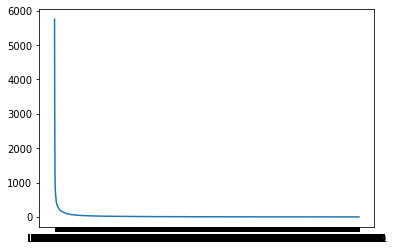

In [143]:
hotspots = filtered_butterfly_data['ebird_hotspot'].value_counts()

print(hotspots)

print(len(hotspots > 1000))
print(hotspots.min(), hotspots.max(), hotspots.mean(), hotspots.median())

value_counts_filtered = hotspots[hotspots > 200]

print(value_counts_filtered)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# plt.hist(hotspots, density=False, bins=30)  # density=False would make counts
plt.plot(hotspots.keys(), hotspots)  # density=False would make counts
plt.show()

In [116]:
del distances
del knn

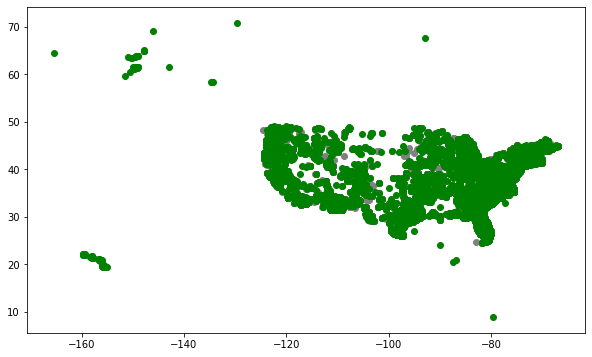

In [204]:
import matplotlib
import matplotlib.pyplot as plt
# import cartopy
# import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# ax.coastlines()

colors = {'train': 'b', 'test':'y', 'valid':'m'}

# ax.plot(tiny_butterfly['decimalLongitude'], tiny_butterfly['decimalLatitude'], 'go', transform=ccrs.PlateCarree())
# ax.plot(tiny_butterfly['ebird_lon'], tiny_butterfly['ebird_lat'], 'ro', transform=ccrs.PlateCarree())

ax.scatter(x=filtered_butterfly_data['ebird_lon'], y=filtered_butterfly_data['ebird_lat'], color='grey')
# ax.scatter(x=filtered_butterfly_data['decimalLongitude'], y=filtered_butterfly_data['decimalLatitude'], color='red')
ax.scatter(x=center_lons, y=center_lats, color='green')

# ax.scatter(x=tiny_satbird['lon'], y=tiny_satbird['lat'], color='blue')

plt.show()

ax.set_title('Coordinates on USA Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [14]:
filtered_butterfly_data

,index,Unnamed: 0,gbifID,abstract,accessRights,accrualMethod,accrualPeriodicity,accrualPolicy,alternative,audience,...,level2Name,level3Gid,level3Name,iucnRedListCategory,eventType,ebird_hotspot,ebird_lon,ebird_lat,distance,ebird_split
0,0,0,3922908706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Plymouth,NaN,NaN,NE,NaN,L483419,-70.853791,42.239861,0.236630,train
1,3,3,3922904710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Ulster,NaN,NaN,NE,NaN,L5986088,-74.213514,41.635127,0.009726,valid
2,4,4,3922908720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,New York,NaN,NaN,LC,NaN,L2391396,-73.953715,40.794443,0.009534,train
3,5,5,3922908725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Hidalgo,NaN,NaN,NE,NaN,L5087869,-97.965891,26.063190,0.003394,train
4,6,6,3922908726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Hidalgo,NaN,NaN,NE,NaN,L5087869,-97.965891,26.063190,0.003394,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162355,225854,225854,3397369406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Barnstable,NaN,NaN,LC,NaN,L1071021,-70.130271,41.756659,0.072127,train
162356,225855,225855,3397369407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Washtenaw,NaN,NaN,NE,NaN,L1495223,-83.866233,42.251496,0.012006,train
162357,225856,225856,3397369418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,York,NaN,NaN,NE,NaN,L1748315,-70.892580,43.321171,0.719531,test
162358,225857,225857,3427427343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Rutland,NaN,NaN,NE,NaN,L3695651,-73.021499,43.711654,0.256585,valid


# 3. group butterfly checklists based on final hotspots

In [35]:
grouped_butterfly_data = filtered_butterfly_data.groupby(['ebird_hotspot'])
group_sizes = grouped_butterfly_data.size()
print(group_sizes)

ebird_hotspot
L1000300       16
L10004496      18
L1000726        2
L1001421       10
L10016800       1
             ... 
L998165        11
L998197         2
L998198        11
L998199         3
L998897      1301
Length: 6712, dtype: int64


In [43]:
print(filtered_butterfly_data["species"].value_counts())

Pieris rapae         6829
Danaus plexippus     6731
Phyciodes tharos     5308
Papilio glaucus      3837
Colias philodice     3609
                     ... 
Mimoides phaon          1
Eurema salome           1
Papilio andraemon       1
Rekoa palegon           1
Papilio garamas         1
Name: species, Length: 602, dtype: int64


In [37]:
# save species list of all unique species

species_list = filtered_butterfly_data["species"].unique().tolist()
print(species_list)
print(len(species_list))

species_df = filtered_butterfly_data['species'].value_counts()

species_df = species_df.reset_index()
species_df.columns = ['species', 'frequency']

species_df.to_csv(os.path.join(root_dir, dataset_tag, 'species_list.csv'), index=False)

print(species_df)

['Coenonympha tullia', 'Strymon melinus', 'Danaus plexippus', 'Phoebis agarithe', 'Phyciodes phaon', 'Plebejus saepiolus', 'Mitoura spinetorum', 'Poanes viator', 'Euphyes vestris', 'Colias alexandra', 'Hesperia juba', 'Vanessa atalanta', 'Battus philenor', 'Hesperia comma', 'Epargyreus clarus', 'Phyciodes tharos', 'Polygonia faunus', 'Colias meadii', 'Atalopedes campestris', 'Speyeria aphrodite', 'Mastor celia', 'Glaucopsyche lygdamus', 'Speyeria cybele', 'Speyeria coronis', 'Pieris rapae', 'Celastrina lucia', 'Erynnis horatius', 'Wallengrenia otho', 'Cercyonis pegala', 'Harkenclenus titus', 'Cyaniris neglecta', 'Danaus gilippus', 'Colias philodice', 'Papilio glaucus', 'Polites coras', nan, 'Dione vanillae', 'Pholisora catullus', 'Hylephila phyleus', 'Polygonia comma', 'Euptoieta claudia', 'Papilio polyxenes', 'Limenitis arthemis', 'Elkalyce comyntas', 'Phoebis sennae', 'Lerema accius', 'Vanessa virginiensis', 'Libytheana carinenta', 'Papilio troilus', 'Nymphalis antiopa', 'Erynnis bap

In [18]:
total_number_of_checklists = len(filtered_butterfly_data["eventID"].unique().tolist())
print(total_number_of_checklists)

29300


In [44]:
# create targets by aggregating checklists
import json

for group_name, group_data in tqdm(grouped_butterfly_data):
#     print(group_name, group_data['eventID'], group_data['occurrenceID'],
#           group_data['taxonID'], group_data['decimalLatitude'], group_data['decimalLongitude'])
    target = {}
    checklist_ = np.zeros(len(species_list))
    for sp in group_data["species"]:
        checklist_[species_list.index(sp)] += 1
    target['num_complete_checklists'] = len(group_data['eventID'].unique())
    checklist_ = checklist_ / target['num_complete_checklists']
    target['probs'] = checklist_.tolist()
    target['hotspot_id'] = group_name

    with open(os.path.join(root_dir, dataset_tag, 'butterfly_targets', group_name + '.json'), 'w') as fp:
        json.dump(target, fp)


  0%|                                                                                                                                                       | 0/3 [00:00<?, ?it/s]


KeyError: 'species'

In [38]:
# create final csv
# columns: hotspot_name, lon, lat, number_of_observations, number_of_unique_checklists, number_of_unique_species, env variables
hotspot_ids = []
lats, lons = [], []
number_of_butterfly_obs = []
number_of_unique_checklists = []
number_of_different_species = []

bio_env_column_names = ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5',
       'bio_6', 'bio_7', 'bio_8', 'bio_9', 'bio_10', 'bio_11', 'bio_12',
       'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18', 'bio_19']
ped_env_column_names = ['bdticm', 'bldfie', 'cecsol', 'clyppt', 'orcdrc', 'phihox', 'sltppt', 'sndppt']
location_info = ['county_code', 'state', 'state_code']

for group_name, group_data in tqdm(grouped_butterfly_data):
    hotspot_ids.append(group_name)
    lats.append(group_data['ebird_lat'].iloc[0])
    lons.append(group_data['ebird_lon'].iloc[0])
    number_of_butterfly_obs.append(len(group_data['occurrenceID']))
    number_of_unique_checklists.append(len(group_data['eventID'].unique()))
    number_of_different_species.append(len(group_data['species'].unique()))

final_data_frame = pd.DataFrame({'hotspot_id': hotspot_ids,
                                 'lat': lats,
                                 'lon': lons,
                                 'ebutterfly_occurances': number_of_butterfly_obs,
                                 'num_checklists': number_of_unique_checklists,
                                 'num_species': number_of_different_species})
    

indices = satbird_USA_summer[satbird_USA_summer['hotspot_id'].isin(final_data_frame['hotspot_id'])].index

bio_env_indices = [satbird_USA_summer.columns.get_loc(c) for c in bio_env_column_names]
ped_env_indices = [satbird_USA_summer.columns.get_loc(c) for c in ped_env_column_names]
location_info_indices = [satbird_USA_summer.columns.get_loc(c) for c in location_info]

final_data_frame[bio_env_column_names] = satbird_USA_summer.iloc[indices, bio_env_indices].values
final_data_frame[ped_env_column_names] = satbird_USA_summer.iloc[indices, ped_env_indices].values
final_data_frame[location_info] = satbird_USA_summer.iloc[indices, location_info_indices].values


print(final_data_frame)

final_data_frame.to_csv(os.path.join(root_dir, dataset_tag, 'butterfly_hotspots.csv') , index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6712/6712 [00:01<00:00, 4174.24it/s]


     hotspot_id        lat         lon  ebutterfly_occurances  num_checklists  \
0      L1000300  33.385730  -81.918526                     16               3   
1     L10004496  26.275705  -81.820099                     18               2   
2      L1000726  35.084377 -106.620340                      2               1   
3      L1001421  27.252073  -82.295752                     10               1   
4     L10016800  31.577595 -110.935079                      1               1   
...         ...        ...         ...                    ...             ...   
6707    L998165  36.073231  -78.863208                     11               2   
6708    L998197  35.753159  -78.958131                      2               2   
6709    L998198  35.614933  -79.159363                     11               2   
6710    L998199  36.080626  -78.755137                      3               1   
6711    L998897  42.921078  -73.236537                   1301             135   

      num_species      bio_

# 4. split data using DBSCAN (script: make_splits_by_distance.py)

In [39]:
butterfly_data_with_split = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_with_splits.csv"))

In [40]:
butterfly_data_with_split

,Unnamed: 0,index,hotspot_id,lat,lon,ebutterfly_occurances,num_checklists,num_species,bio_1,bio_2,...,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt,county_code,state,state_code,split
0,0,0,L1000300,33.385730,-81.918526,16,3,12,20.237499,8.191667,...,36.0,15.0,45.0,53.0,26.0,59.0,US-AL-003,Alabama,US-AL,valid
1,1,1,L10004496,26.275705,-81.820099,18,2,12,19.045834,11.858334,...,7.0,11.0,14.0,47.0,25.0,64.0,US-AL-003,Alabama,US-AL,test
2,2,2,L1000726,35.084377,-106.620340,2,1,2,18.150000,13.250000,...,14.0,18.0,12.0,54.0,21.0,62.0,US-AL-005,Alabama,US-AL,train
3,3,4800,L557941,38.512647,-122.103167,1,1,1,17.879168,12.958334,...,15.0,20.0,12.0,52.0,23.0,57.0,US-AL-011,Alabama,US-AL,test
4,4,3,L1001421,27.252073,-82.295752,10,1,10,15.745833,13.724999,...,14.0,17.0,11.0,53.0,52.0,31.0,US-AL-043,Alabama,US-AL,valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6707,6707,4789,L554961,41.673108,-87.905860,50,13,18,1.962500,16.025000,...,26.0,16.0,52.0,59.0,38.0,46.0,US-WY-039,Wyoming,US-WY,train
6708,6708,6709,L998198,35.614933,-79.159363,11,2,11,1.375000,16.299999,...,26.0,19.0,27.0,62.0,34.0,46.0,US-WY-039,Wyoming,US-WY,valid
6709,6709,6710,L998199,36.080626,-78.755137,3,1,3,1.120833,15.808333,...,24.0,15.0,35.0,60.0,42.0,44.0,US-WY-039,Wyoming,US-WY,test
6710,6710,5817,L755972,46.291562,-122.265816,1,1,1,6.837500,14.408333,...,23.0,19.0,23.0,61.0,39.0,41.0,NaN,New Mexico,US-NM,train


In [41]:
grouped_butterfly_data = butterfly_data_with_split.groupby(['split'], as_index=False)

for group_name, group_data in tqdm(grouped_butterfly_data):
    print(group_name)
    print(group_data["ebutterfly_occurances"].max())
    group_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_" + str(group_name) + ".csv"))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.38it/s]

test
1245
train
5753
valid
3479


# 5. Visualize map after splitting

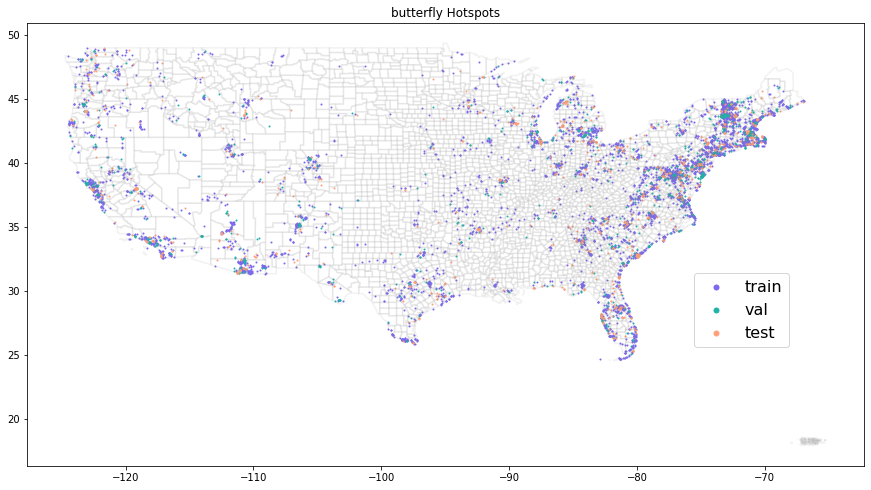

In [42]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))

import numpy as np
import pandas as pd
import json

import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

path = os.path.join(root_dir, dataset_tag, "butterfly_hotspots_with_splits.csv")

df = pd.read_csv(path)
df = df.drop_duplicates("hotspot_id")

geoDatav = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)   


train = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_train.csv"))
val = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_valid.csv"))
test = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_test.csv"))
gdf["split"] = ""

idx = gdf[gdf["hotspot_id"].isin(list(train["hotspot_id"]))].index
gdf.loc[idx,"split"] = "train"

idx = gdf[gdf["hotspot_id"].isin(list(val["hotspot_id"]))].index
gdf.loc[idx,"split"] = "val"
idx = gdf[gdf["hotspot_id"].isin(list(test["hotspot_id"]))].index
gdf.loc[idx,"split"] = "test"

ig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin(["02", "15"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
gdf[gdf["split"]=="train"].plot(ax=ax,marker='o', color='mediumslateblue', markersize=1, label = "train")
gdf[gdf["split"]=="val"].plot(ax=ax, marker='o', color='lightseagreen', markersize=1, label = "val")
gdf[gdf["split"]=="test"].plot(ax=ax, marker='o', color='lightsalmon', markersize=1, label = "test")

plt.legend(fontsize=16, markerscale=5,loc='lower right',  bbox_to_anchor=(0.92, 0.25))
plt.title("butterfly Hotspots")
plt.savefig("hotspotsus.png")
plt.show()

Final files saved:
[('valid', 1006), ('test', 1014), ('train', 4692)]
- butterfly_hotspots.csv
- butterfly_hotspots_train.csv
- butterfly_hotspots_valid.csv
- butterfly_hotspots_test.csv
- species_list.csv
- targets/